In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from trl import SFTTrainer
import itertools
import pandas as pd
import os
from dataset_preprocessing import TokenInfo
import torch
from tqdm import tqdm

/home/daniel/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from os import listdir

In [3]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [4]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

/home/daniel/miniconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
def get_mlps(model):
    layers = model.get_submodule("model").get_submodule("layers")
    return [layer.get_submodule("mlp") for layer in layers]

mlps = get_mlps(model)

In [6]:
def get_lm_prunner_style_importances(model):
    mlps = get_mlps(model)
    imps = {}
    imps_list = pd.read_pickle("average_importances_sorvisto.pkl")
    for mlp, imp in zip(mlps, imps_list):
        imps[mlp] = imp
    return imps


In [7]:
avg_imps = get_lm_prunner_style_importances(model)

In [8]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [9]:
import matplotlib.pyplot as plt

@torch.no_grad()
def pruning_magnitude_comparison(importances, prune_ratio):
    """ Given a dictionary of mlp -> importance tensor, prunes
    all the mlps holistically.
    """

    # Concatenate all importance tensors
    concat_imps = torch.cat(list(importances.values())).float()

    num_prune_cells = int(len(concat_imps) * prune_ratio)

    # Choose which node-indexes to prune, mark those indexes with '0'
    _, indices_to_replace = torch.topk(concat_imps, num_prune_cells, largest=False)
    concat_imps[indices_to_replace] = 0
    
    # Make a new dict with indexes with smallest values zeroed out
    split_size = len(list(importances.values())[0])
    pruned_tensors = torch.split(concat_imps, split_size)
    pruned_tensors = [ten[ten != 0] for ten in pruned_tensors]

    tensor_lengths = [len(tensor) for tensor in pruned_tensors]
    # Plotting the histogram

    x_labels = [str(i) for i in range(len(tensor_lengths))]

    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, tensor_lengths)
    plt.show()

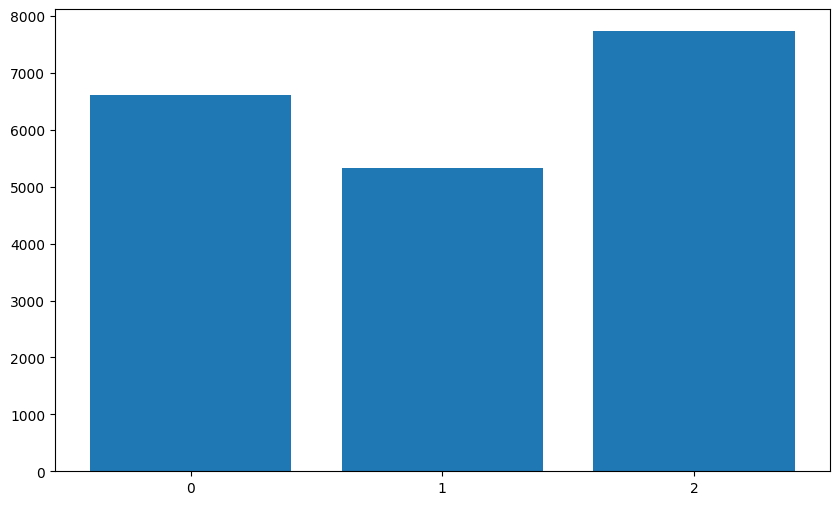

In [10]:
pruning_magnitude_comparison(avg_imps, 0.2)

In [11]:
from prunners import prune_mlps_holistically

In [13]:
prune_mlps_holistically(avg_imps, 0.2)